In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from evspy.multi_stage_model.decoupled_fdm import distorted_isotache_model

import evspy.utils.loading_empirical_data as loading_data
from evspy.utils.loadsteps import LoadSteps, identify_all_stages
from evspy.utils.helper_functions import get_sigref

# Test results for AOS test

In [4]:
readings = {}
metadata_readings = {}
data_store = '../../data/AOS_test_results_Vergote2021.hdf'
with pd.HDFStore(data_store) as hdf:
    test=hdf.keys()
    for tst in test:
        readings[tst], metadata_readings[tst] = loading_data.h5load(hdf,tst)

In [5]:
# Parameters
# ----------
Cc = 1.07; Cr = Cc/4.3; CalphaNC = Cc*0.04
e0 = 4;
beta2 = 4; beta3 = 21.5
m1 = 0.95; b1 = -0.84; m2 = 2.5; b2 = -3.3
e_ref=3.68; e_init=3.8
H = readings['/2b']['sample_height'].dropna().iloc[0]

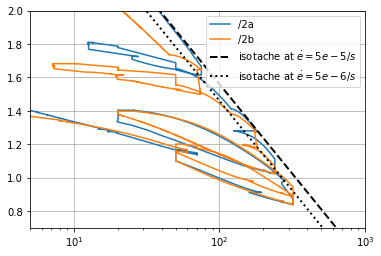

In [6]:
for key in ['/2a','/2b']:
    plt.semilogx(readings[key]['load'],readings[key]['void_ratio'],'-',label=key)


e_ref1=3.8;e0 = e_ref1-0.1; e_ref2 = e0-0.1; e_ref3 =3.4

plt.plot(10**np.arange(-1,3,0.1),e0-Cc*np.arange(-1,3,0.1),'k--',lw=2,label='isotache at $\dot{e} = 5e-5/s$')
plt.plot(10**np.arange(-1,3,0.1),e_ref2-Cc*np.arange(-1,3,0.1),'k:',lw=2,label='isotache at $\dot{e} = 5e-6/s$')

plt.legend(); plt.xlim(5,1000); plt.ylim(0.7,2)
plt.grid()

In [7]:
# Identify stages
stage_info={}
for key in ['/2a','/2b']:
    stage_info[key] = identify_all_stages(readings[key])
    for i in list(stage_info[key]):
        stage_info[key][i]['sigp_ref']=get_sigref(stage_info[key][i]['initial_load'],stage_info[key][i]['initial_void_ratio'],Cc,Cr,e0)[0]
        if stage_info[key][i]['type']=='R':
            stage_info[key][i]['OCR_ref']=stage_info[key][i]['sigp_ref']/stage_info[key][i]['initial_load']
        else:
            stage_info[key][i]['sigp_ref']=get_sigref(stage_info[key][i]['final_load'],stage_info[key][i]['final_void_ratio'],Cc,Cr,e0)[0]
            stage_info[key][i]['OCR_ref']=stage_info[key][i]['sigp_ref']/stage_info[key][i]['final_load']

# Build load stages
load = {}
for key in ['/2a','/2b']:
    load[key] = LoadSteps()
    maxload = 0
    for stage in stage_info[key]:
        max_load = np.max([maxload,stage_info[key][stage]['final_load']])
        if stage_info[key][stage]['type']=='R':
            stage_info[key][stage]['strain_rate'] = 0
            stage_info[key][stage]['type']='CRS'
        if stage_info[key][stage]['type']=='CL':
            stage_info[key][stage]['strain_rate'] = 0
            stage_info[key][stage]['type']='IL'
        if stage_info[key][stage]['initial_load']<maxload:
            cv = 7
        else:
            cv = 40
        load[key].add_load_step(stage_info[key][stage]['duration'],stage_info[key][stage]['final_load'],-stage_info[key][stage]['strain_rate'],stage_info[key][stage]['type'],cv)
    
sigma=np.array([stage_info[key][1]['initial_load']])
time=np.array([0])

/home/thomasvergote/.local/share/virtualenvs/DEME-Geo-4NKs8gg9/lib/python3.8/site-packages/evspy/utils/loadsteps.py:57: RuntimeWarning: divide by zero encountered in log10
  return np.mean(np.interp(10**np.linspace(np.log10(100),np.log10(np.max(x)),100),x,y))
/home/thomasvergote/.local/share/virtualenvs/DEME-Geo-4NKs8gg9/lib/python3.8/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


# Model running

In [8]:
model_full = {}
model_no_swelling = {}
for key in ['/2a','/2b']:
    model_full[key] = distorted_isotache_model(load[key],H=H,Calpha_OCRref=False,erateref=5e-4,dimt=100000,
                                                sigma0=0.1,erateinits=1e-30,Cc=Cc,Cr=Cr,CalphaNC=CalphaNC,
                                                ref_func='semilogx',use_power_law=False,m1=m1,b1=b1,m2=m2,b2=b2,
                                                beta2=beta2,beta3=beta3,e0=e_ref1,e_init=e_init,dsig=0.05,
                                                isotache=False)
    model_full[key].initialize_decoupled()
    %time model_full[key].run_iterations(timefactor=2)
    model_no_swelling[key] = distorted_isotache_model(load[key],H=H,Calpha_OCRref=False,erateref=5e-4,dimt=100000,
                                                sigma0=0.1,erateinits=1e-30,Cc=Cc,Cr=Cr,CalphaNC=CalphaNC,
                                                ref_func='semilogx',use_power_law=False,m1=0,b1=-10,m2=0,b2=-10,
                                                beta2=beta2,beta3=beta3,e0=e_ref1,e_init=e_init,dsig=0.05,
                                                isotache=False)
    model_no_swelling[key].initialize_decoupled()
    %time model_no_swelling[key].run_iterations(timefactor=2)

CPU times: user 52.8 s, sys: 0 ns, total: 52.8 s
Wall time: 52.8 s
CPU times: user 53.2 s, sys: 0 ns, total: 53.2 s
Wall time: 53.2 s
CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 5s
CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


# Visualise the results

(0.0, 4.0)

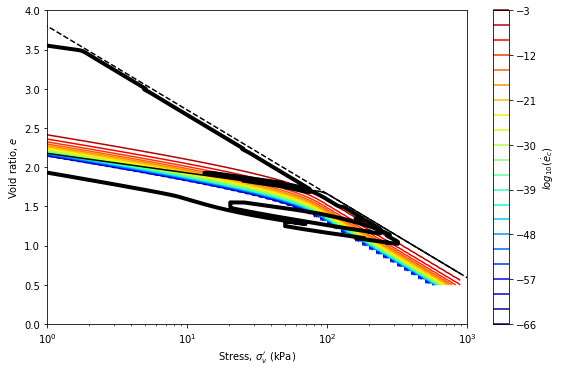

In [9]:
model_full['/2a'].plotting_stresspath(sigp=95)
plt.ylim(0.,4)

In [10]:
def plot_readings(key,step):
    plotdata=readings[key][(readings[key]['step_id']==int(step[-2:]))]
    if 'CR' in step:
        field = 'load'
    else:
        field = 'void_ratio'
    reset = plotdata[field].iloc[0]
    x = 10**np.linspace(np.log10(np.min(plotdata['time'].iloc[1:])),np.log10(np.max(plotdata['time'])),60)
    y = np.interp(np.log10(x),np.log10(np.clip(plotdata['time'],0.1,np.infty)),plotdata[field]-reset)
    plt.semilogx(x,y,'ko',ms=5,fillstyle='none')

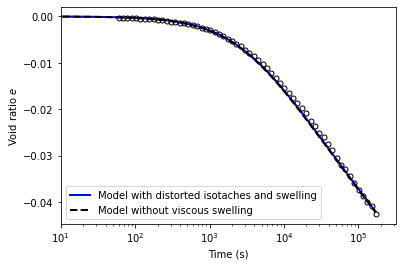

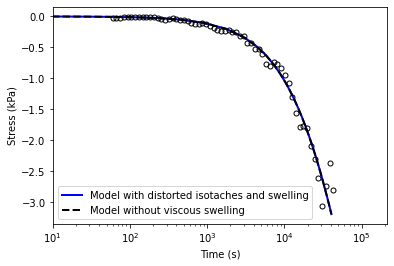

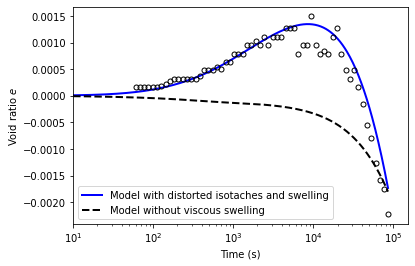

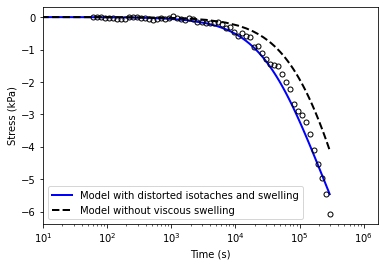

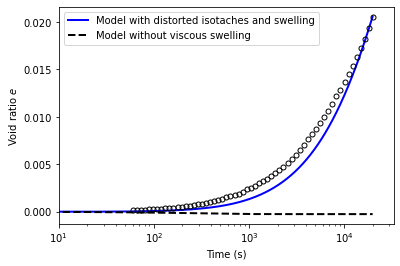

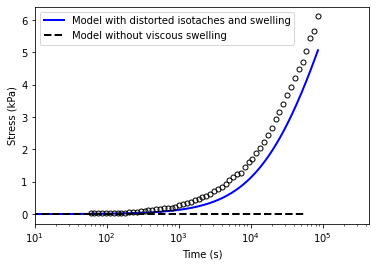

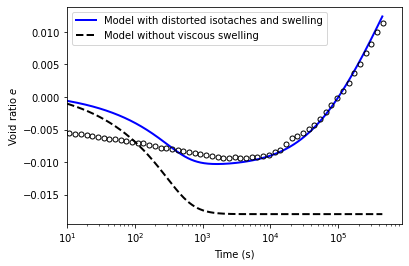

In [11]:
key='/2b'
for step in ['IL24','CRS25','IL21','CRS22','IL29','CRS30','IL50']:
    plt.figure()
    model_full[key].plotting_timeseries(step,set_zero=True,lw=2,color='b',label='Model with distorted isotaches and swelling')
    model_no_swelling[key].plotting_timeseries(step,set_zero=True,lw=2,color='k',ls='--',label='Model without viscous swelling')
    plot_readings(key,step)
    plt.xlim(10,);
    plt.legend()